# Magnipy Tutorial

This tutorial will walk you through using some of the main functionalities of the `Magnipy` package, which is used to compute and compare the magnitude (effective size) of point clouds.

## Importing Packages and Datasets

Before we begin, we must import the packages required for our functionality. Please ensure that you have activated your virtual environment and installed the dependencies using poetry before this step (see **Dependencies** in the README).

In [1]:
# import statements for external packages
from importlib import reload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
# import statements from magnipy repo
from magnipy.magnipy import Magnipy
from tutorial_data import *

We create 3 example datasets according to different distributions, each with 1000 points.

1. **Random Point Cloud from Uniform Distribution**  
Here, we generate random points in a 3D space (i.e. selecting points according to a uniform distribution so that any point is chosen with equal probability.)

2. **Clusters/Blobs**  
Here, we generate a dataset clustered around 5 points.

3. **The Swiss Roll**  
The Swiss Roll is a classic generated dataset that roughly takes the shape of a 2D plane that has been rolled in a spiral, forming a 3D manifold. Here, we use it as a toy example to demonstrate the functionality of our magnipy package.

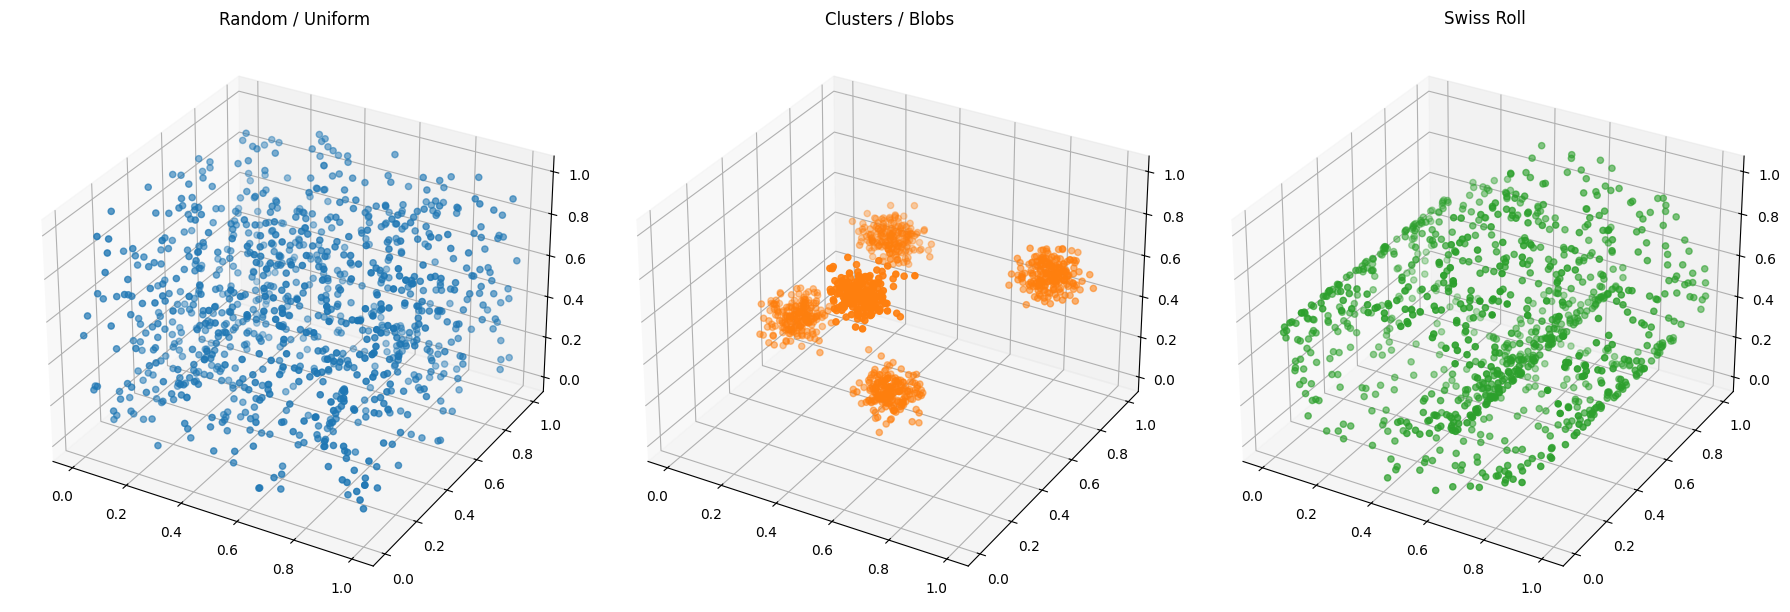

In [2]:
# Grabbing datasets
rando_data, rando_df = get_random()
blobs_data, blobs_df = get_clusters()
sr_data, sr_df = get_swiss_roll()
# Plotting
plot_dfs([rando_df, blobs_df, sr_df], titles=["Random / Uniform", "Clusters / Blobs", "Swiss Roll"])

## Computing Magnitude

To compute magnitude, we first create the Magnipy object for each datset, which we will use to call our magnitude methods.

In [3]:
# Creating a Magnipy instance for each dataset
rando = Magnipy(rando_data, name='Random')
blobs = Magnipy(blobs_data, name='Clustered/Blobs')
swiss_roll = Magnipy(sr_data, name='Swiss Roll')
mags = [rando, blobs, swiss_roll]

We can now call the Magnipy methods on each of these instances. Computing and visualizing the magnitude across distance scales is as simple as calling the `plot_magnitude_function()` method.

Text(0.5, 1.0, 'Plotting Magnitude with Magnipy')

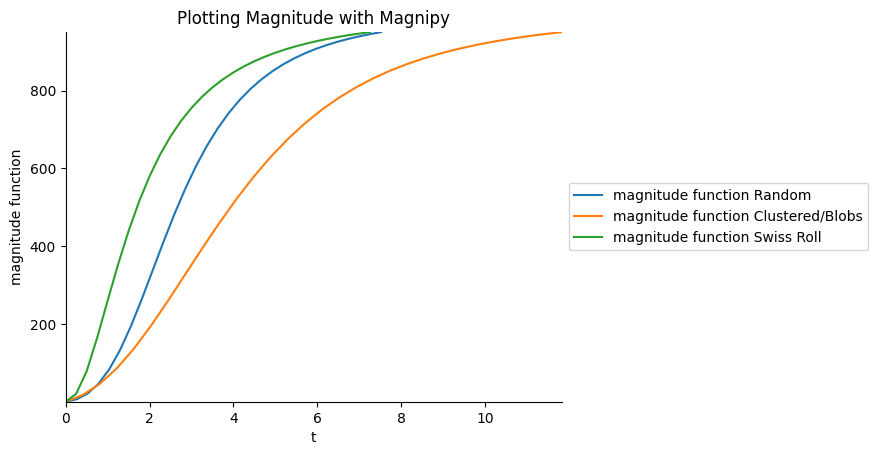

In [4]:
# Plotting magnitude
for mag in mags:
    mag.plot_magnitude_function()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(enable=True, axis='both', tight=True)
plt.title("Plotting Magnitude with Magnipy")

Recall that **t** is our distance scaling factor. This means any pairwise distance between points is scaled by a factor of t. We can visualize an increase in **t** as 'zooming in', where points spread further away from each other.

When **t** is 0, the points have distance 0 from each other, and thus are effectively 1 point. As **t** increases, we 'zoom in' and the distance between points increases as they spread out. Thus the magnitude / effective size also increases. Finally, **t** plateaus at the cardinality of the dataset, in this case 1000.

By default, we compute magnitude until it reaches 95% of the cardinality. (See section _"Determining Convergence Scales and Evaluation Intervals"_ below).

## Zooming In: Breakdown of Magnitude Pipeline

How does Magnipy compute magnitude? In this section, we walk through the process step by step:

1. Computing the Distance Matrix
2. Creating the Similarity Matrix
3. Determining Convergence Scales and Evaluation Intervals
4. Computing Magnitude Weights
5. Aggregating for Overall Magnitude

### 1. Computing the Distance Matrix

Recall the **t** is a scaling factor for the distance between points in the metric space. We compute a distance matrix that stores the pairwise distances between points in the metric space. (The dimensions of this matrix are |X| by |X|). This can then be easily scaled by our scaling factor **t**.

In [5]:
# Computing distance matrix with get_dist()
rando_dist = rando.get_dist()
blob_dist = blobs.get_dist()
swiss_dist = swiss_roll.get_dist()

We can visualize these distance matrices below, with the x- and y- axes representing the index of each point in the dataset. Small distances are represented in dark purple and large distances in light green. Note that distance when x=y (i.e. distance between a point and itself) is always 0.

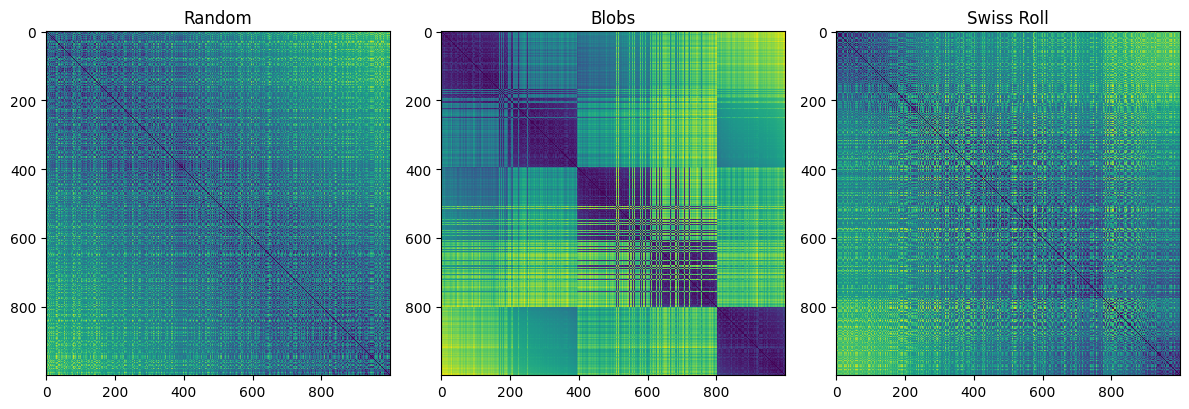

In [6]:
# Visualization of distance matrices
plot_matrices([rando_dist, blob_dist, swiss_dist], 
              ["Random", "Blobs", "Swiss Roll"])

##### Customizing Distance Calculation

When initializing the Magnipy object, you can customize which distance metric you want to use. The default is to use Euclidean distance. See `magnipy.py` for a complete list of all supported metrics.

### 2. Creating the Similarity Matrix

The distance ($d$) and similarity ($\zeta$) of two points _a_ and _b_ are related in the following way: $\zeta(a, b) = e^{(-d(a,b))}$

That is, the further two points are from each other (i.e. the larger the distance between them), the less "similar" they are. We use this simple relationship to calculate the similarity matrix from the distance matrix.

In [7]:
# Computing similarity matrices
rando_sim = rando.get_similarity_matrix()
blobs_sim = blobs.get_similarity_matrix()
swiss_sim = swiss_roll.get_similarity_matrix()

We can visualize these similarity matrices similarly to how we visualized distance. Low similarity values are represented by dark purple and higher similarity by yellow/light green. Note that **all similarity values fall between 0 and 1.**

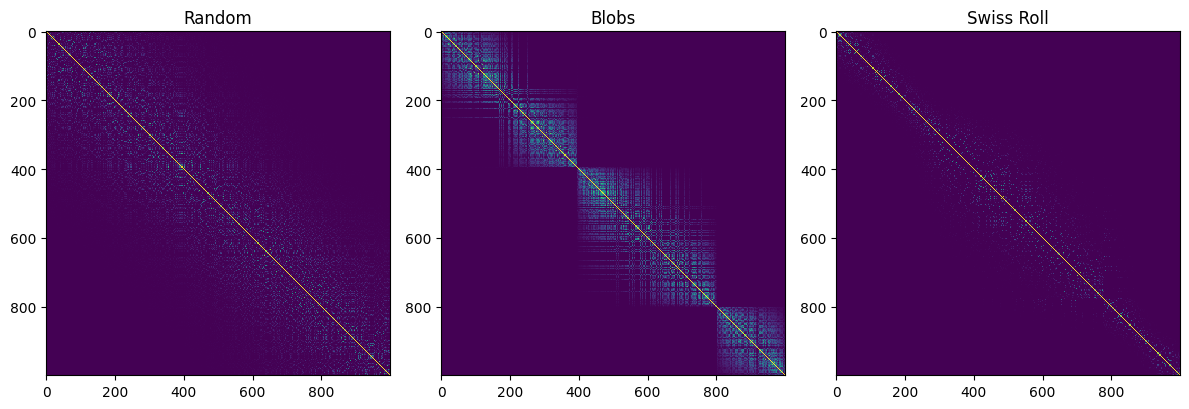

In [8]:
# Visualizing similarity matrices
plot_matrices([rando_sim, blobs_sim, swiss_sim], 
              ["Random", "Blobs", "Swiss Roll"])

### 3. Determining Convergence Scales and Evaluation Intervals

**_Q: How does Magnipy decide which values of **t** to compute magnitude for?_**

By default, we automatically estimate the **convergence scale** for a space: that is, when the magnitude will reach 95% of its cardinality.

Recall that when we plotted the magnitude functions, the random and swiss roll datasets converged towards their cardinality much faster than that of the clusters dataset. Thus, we expect their convergence scales to be much lower. This idea is confirmed by the convergence scales of the three datasets.

In [9]:
# Get convergence scale with .get_t_conv()
for mag in mags:
    print(f"{mag.get_name()} dataset converges at: {mag.get_t_conv():.2f}.")


Random dataset converges at: 7.52.
Clustered/Blobs dataset converges at: 11.82.
Swiss Roll dataset converges at: 7.25.


We define each function's **evaluation interval** from zero until this convergence scale, and divide it evenly into `n_ts` values (default=100).

In [10]:
# Get evaluation interval for with .get_scales()
rando_ts = rando.get_scales()
print(f"Evaluation interval for Dataset #1: [{rando_ts[0]:.2f}, {rando_ts[1]:.2f}, {rando_ts[2]:.2f}, ..., {rando_ts[-1]:.2f}].")

Evaluation interval for Dataset #1: [0.00, 0.26, 0.52, ..., 7.52].


##### Customizing Evaluation Scales

There are other ways to customize the way that evaluation scales are computed when creating a Magnipy object, including:

- Manually entering t values via the `ts` parameter (default = None)
- Altering the number of t values  via the `n_ts` parameter (default = 100)
- Using a log scale by setting `log_scale = True` (default = False)
- Changing the proportion of cardinality the magnitude function converges to via `target_prop` (default = 0.95)
- Changing the method from "convergence" to "scattered" via the `scale_finding` parameter (default = "convergence")

See the `magnipy.py` file for descriptions of all evaluation scale parameters.

### 4. Computing Magnitude Weights

Before finding the magnitude of the whole space at each time scale, we first compute the individual **magnitude weights** for each of point at each time scale. Magnitude weights can be computed according to several different methods. You can select your preferred method via the `method` parameter when initializing a Magnipy object (**default = "cholesky"**). Note that magnitude weights **increase monotonically** as the scaling factor increases.

In [11]:
# Computing magnitude weights with get_magnitude_weights() method
rando_weights, rando_ts = rando.get_magnitude_weights()
# rando_weights.shape = (1000=|X|, 30=n_ts)
# rando_ts.shape = (30=n_ts,)

blobs_weights, blobs_ts = blobs.get_magnitude_weights()
swiss_weights, swiss_ts = swiss_roll.get_magnitude_weights()

In [19]:
print(rando_ts[14])
print(blobs_ts[14])

3.6299184203923085
5.707001251076032


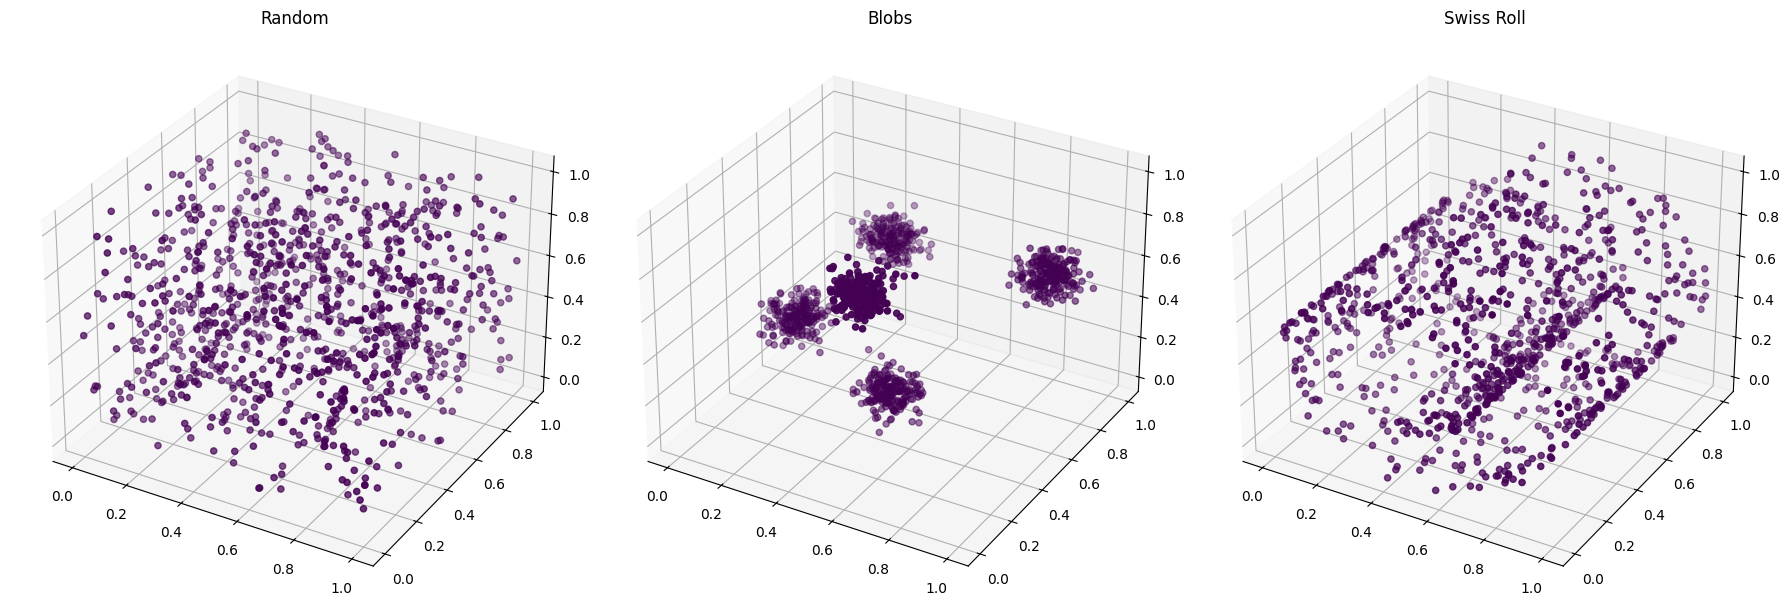

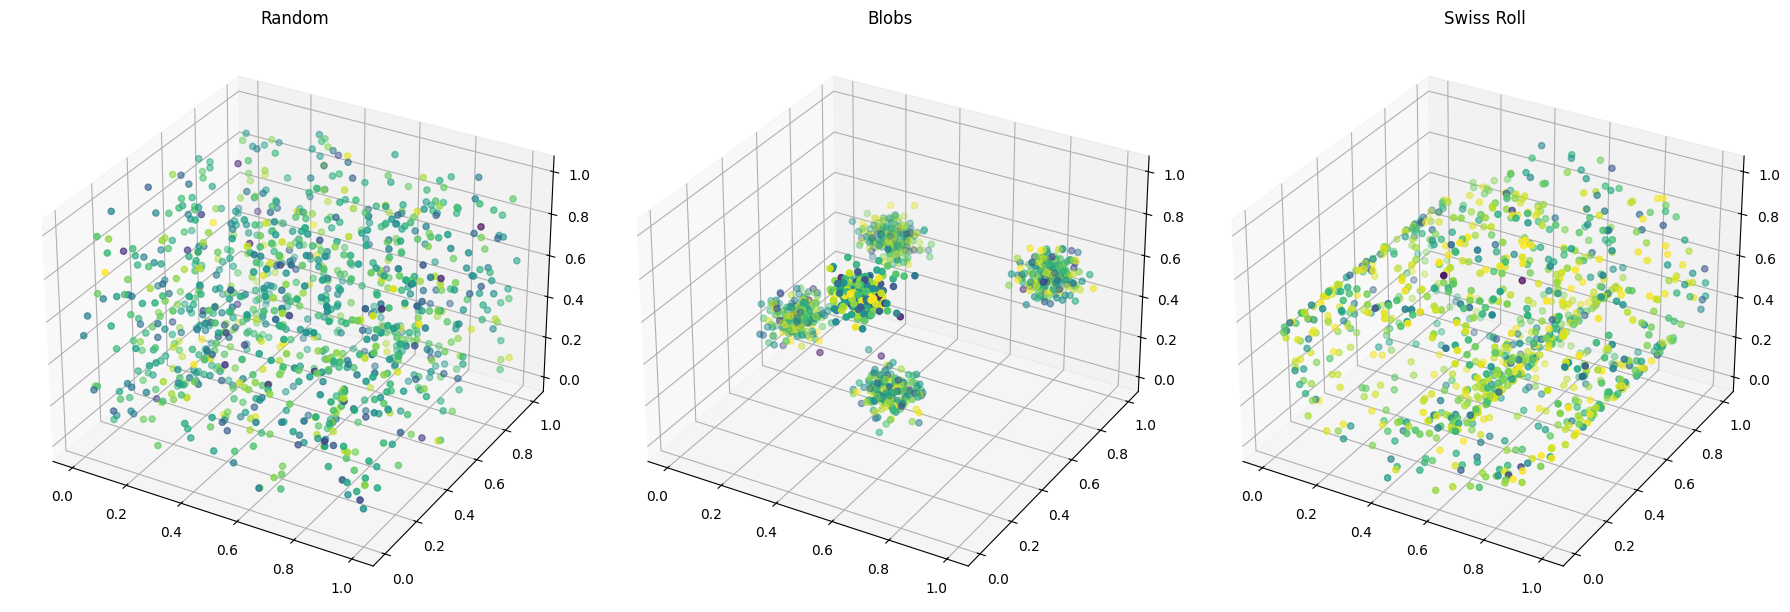

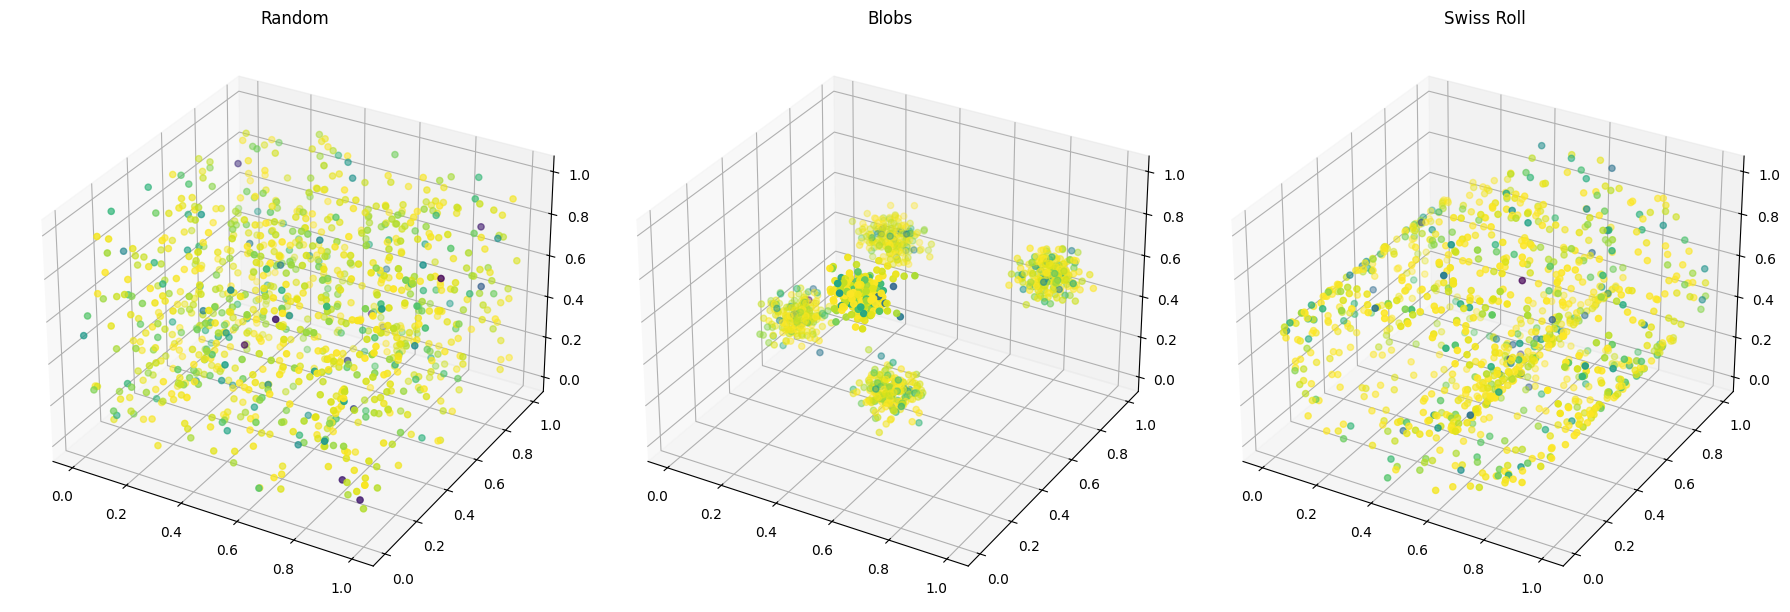

In [20]:
# Plotting magnitude weights when t=0
for idx in [0, 14, 29]:
    plot_magnitude_weights(
        [rando_df, blobs_df, sr_df],
        [rando_weights[:,idx], blobs_weights[:,idx], swiss_weights[:,idx]],
        ["Random", "Blobs", "Swiss Roll"]
    )

### 5. Aggregating for Overall Magnitude

The overall magnitude of a space at scaling factor t is simply the sum of the individual magnitude weights at scaling factor t. Thus, it must also monotonically increase with t.

In [15]:
# Getting magnitude values for Dataset #1
rando_magnitude_vals, rando_t_vals = rando.get_magnitude()
print(f"t \t Magnitude")
for i in range(0,len(rando_magnitude_vals)):
    print(f"{rando_t_vals[i]:.2f} \t {rando_magnitude_vals[i]:.2f}")

t 	 Magnitude
0.00 	 1.00
0.26 	 7.31
0.52 	 21.64
0.78 	 46.55
1.04 	 83.83
1.30 	 133.82
1.56 	 195.10
1.81 	 264.58
2.07 	 338.25
2.33 	 412.10
2.59 	 482.82
2.85 	 548.16
3.11 	 606.92
3.37 	 658.74
3.63 	 703.81
3.89 	 742.65
4.15 	 775.95
4.41 	 804.41
4.67 	 828.71
4.93 	 849.48
5.19 	 867.26
5.44 	 882.52
5.70 	 895.65
5.96 	 906.98
6.22 	 916.79
6.48 	 925.32
6.74 	 932.75
7.00 	 939.26
7.26 	 944.97
7.52 	 950.00


Text(0.5, 1.0, 'Plotting Magnitude with Magnipy')

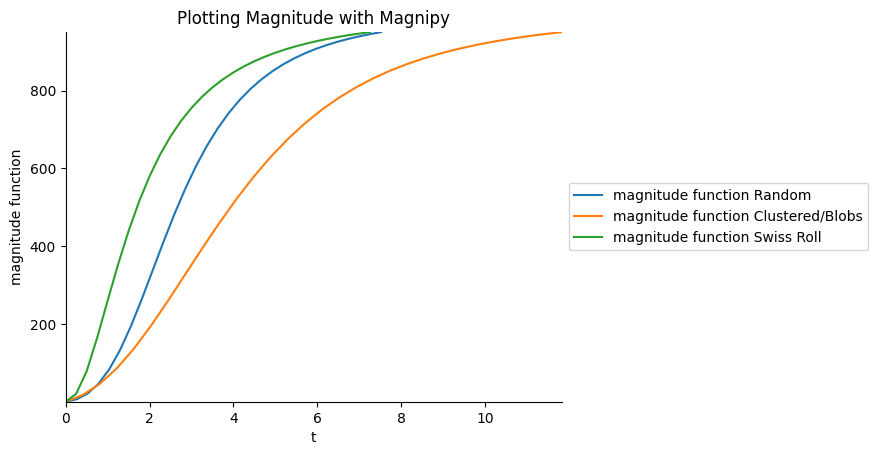

In [16]:
# Plotting magnitude again
for mag in mags:
    mag.plot_magnitude_function()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(enable=True, axis='both', tight=True)
plt.title("Plotting Magnitude with Magnipy")

###  Nice work!

This concludes the Magnipy tutorial.

To investigate how magnitude can act as a metric for quantifying the diversity of a metric space, please see our Diversipy Tutorial (`diversipy_tutorial.ipynb`).